In [1]:
import sys

sys.argv = ['']
sys.path.append("../..")
from src.grid_world import GridWorld
from examples.agent import Agent
import numpy as np

In [2]:
class QLearning_On_Policy(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=0.1, epsilon=0.1):
        """
        Sarsa (on-policy TD control)
        """
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )
        self.alpha = alpha

    def run(self):
        for episode in range(self.num_episodes):
            self.env.reset()
            s0 = self.env.start_state
            st = s0
            while st != self.env.target_state:
                at_idx = self.choose_action(self.state2idx(st))
                at = self.idx2action(at_idx)
                s_next, reward, done, _ = self.env.step(at)

                # Q-Learning update the (st, at) pair
                st_idx = self.state2idx(st)
                at_idx = self.action2idx(at)
                s_next_idx = self.state2idx(s_next)

                TD_target = reward + self.gamma * np.max(self.Q[s_next_idx])
                TD_error = self.Q[st_idx, at_idx] - TD_target

                self.Q[st_idx, at_idx] -= TD_error * self.alpha

                # Q-Learning update the policy
                self.update_policy(st_idx)

                st = s_next

            if (episode + 1) % 500 == 0:
                print(f"Episode {episode + 1} finished.")

    def update_policy(self, st_idx):
        """
        Update policy using epsilon-greedy strategy.
        """
        greedy_action = np.argmax(self.Q[st_idx, :])
        for a in range(self.num_actions):
            if a == greedy_action:
                self.policy[st_idx, a] = 1 - self.epsilon + (self.epsilon / self.num_actions)
            else:
                self.policy[st_idx, a] = self.epsilon / self.num_actions


Episode 500 finished.
Episode 1000 finished.
Episode 1500 finished.
Episode 2000 finished.
Episode 2500 finished.
Episode 3000 finished.
Episode 3500 finished.
Episode 4000 finished.
Episode 4500 finished.
Episode 5000 finished.


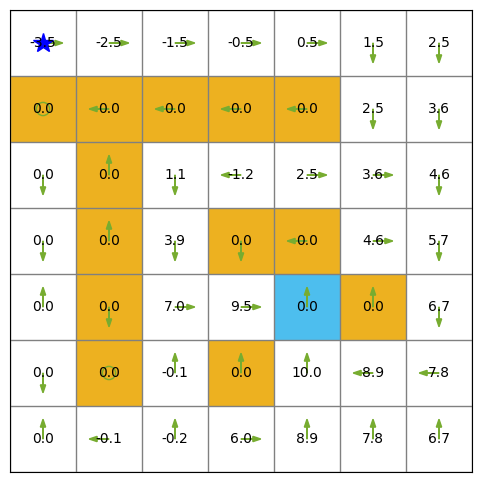

In [3]:
env = GridWorld()
agent = QLearning_On_Policy(env, epsilon=0.2, gamma=0.99, num_episodes=5000, episode_length=1000)
agent.run()
agent.render_static()

In [4]:
class QLearning_Off_Policy(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=0.1, epsilon=0.1, update_freq=10):
        """
        Q-Learning (off-policy TD control).
        behavior policy: self.policy (epsilon-greedy on Q，运动时按此采样)
        target policy: greedy on Q_target，仅用于 TD 目标计算；每 update_freq 步更新一次。
        """
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )
        self.alpha = alpha
        self.update_freq = update_freq
        self.target_policy = np.zeros_like(self.policy)
        self.Q_target = np.zeros_like(self.Q)  # TD 目标用 target policy 的 Q
        # policy: behavior policy (运动时根据此选择动作)
        # target_policy / Q_target: 每 update_freq 步更新，用于计算 TD target

    def run(self):
        for episode in range(self.num_episodes):
            self.env.reset()
            s0 = self.env.start_state
            st = s0
            step_count = 0
            while st != self.env.target_state:
                # 1. 运动：根据 behavior policy (self.policy) 选择动作
                at_idx = self.choose_action(self.state2idx(st))
                at = self.idx2action(at_idx)
                s_next, reward, done, _ = self.env.step(at)

                st_idx = self.state2idx(st)
                at_idx = self.action2idx(at)
                s_next_idx = self.state2idx(s_next)

                # 2. TD 更新：用 target policy 的 Q_target 计算 TD target
                TD_target = reward + self.gamma * np.max(self.Q_target[s_next_idx])
                TD_error = self.Q[st_idx, at_idx] - TD_target
                self.Q[st_idx, at_idx] -= TD_error * self.alpha

                # 3. 更新 behavior policy（epsilon-greedy on Q），保证下一步仍按 policy 运动
                self.update_behavior_policy(st_idx)

                step_count += 1
                # 4. 每 update_freq 步更新 target policy 与 Q_target
                if step_count % self.update_freq == 0:
                    self.Q_target[:] = self.Q
                    self.update_target_policy()

                st = s_next

            if (episode + 1) % 500 == 0:
                print(f"Episode {episode + 1} finished.")

    def get_deterministic_policy(self):
        deterministic_policy = np.zeros_like(self.target_policy)
        for s_idx in range(self.num_states):
            max_q = np.max(self.Q[s_idx])
            best_actions = np.where(self.Q[s_idx] == max_q)[0]
            best_action = np.random.choice(best_actions)
            deterministic_policy[s_idx, best_action] = 1.0
        return deterministic_policy

    def update_behavior_policy(self, st_idx):
        """Behavior policy: epsilon-greedy on Q，运动时按此采样。"""
        greedy_action = np.argmax(self.Q[st_idx, :])
        for a in range(self.num_actions):
            if a == greedy_action:
                self.policy[st_idx, a] = 1 - self.epsilon + (self.epsilon / self.num_actions)
            else:
                self.policy[st_idx, a] = self.epsilon / self.num_actions

    def update_target_policy(self):
        """Target policy: 根据当前 Q_target 更新全部状态的 target_policy（用于展示/评估）。"""
        for s_idx in range(self.num_states):
            greedy_action = np.argmax(self.Q_target[s_idx, :])
            for a in range(self.num_actions):
                if a == greedy_action:
                    self.target_policy[s_idx, a] = 1 - self.epsilon + (self.epsilon / self.num_actions)
                else:
                    self.target_policy[s_idx, a] = self.epsilon / self.num_actions

Episode 500 finished.
Episode 1000 finished.
Episode 1500 finished.
Episode 2000 finished.
Episode 2500 finished.
Episode 3000 finished.
Episode 3500 finished.
Episode 4000 finished.
Episode 4500 finished.
Episode 5000 finished.


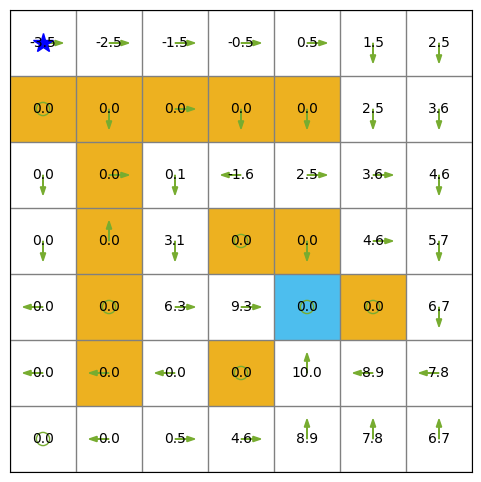

In [5]:
env = GridWorld()
env.reset()
agent = QLearning_Off_Policy(env, epsilon=0.2, gamma=0.99, num_episodes=5000, episode_length=1000, update_freq=10)
agent.run()
agent.render_static()